## 변수선택법

### 1. 전진선택법(Forward Selection)
### 2. 후진소거법(Backward Elimination)
### 3. 단계적선택법(Stepwise Selection)

In [76]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [77]:
# 1. 지하철역개수+버스정거장개수
# 2. 교통편, 인구 밀도 제거

In [78]:
last = pd.read_excel("data/last_자전거이용비율수정.xlsx")
last.fillna(0, inplace=True) # 결측값 0으로 치환 
last = last.drop(last.columns[[0, 6, 9, 13, 14]], axis=1) # unnamed:0 칼럼 지우기
last = last.set_index('동')
last.head()

,경사도,자전거도로길이,총거치대수,총대여수,인구,면적,지하철역개수,버스정거장개수,접근성
동,,,,,,,,,
가락1동,-15.5247,7150,115.0,74652.0,27716,1.34,1,13,12.686567
가락2동,-39.3115,4704,45.0,33583.0,33920,0.96,0,23,23.958333
가락본동,-30.7845,6932,55.0,25487.0,27876,1.13,2,25,29.203540
가리봉동,-21.8088,0,10.0,5621.0,15250,0.40,0,9,22.500000
가산동,-12.9490,2108,258.0,160033.0,24455,2.52,2,111,47.222222


In [79]:
feature_columns = last.columns.difference(["총대여수"]) # Target column 

X = last[feature_columns]
y = last.총대여수

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(296, 8) (128, 8) (296,) (128,)


In [80]:
# train & 회귀모델 적합, 모든 변수를 때려넣었다.

# 회귀분석을 위해 for b0, 상수항 추가
train_x_ = sm.add_constant(train_x, has_constant = "add")

full_model = sm.OLS(train_y, train_x_)
fitted_full_model = full_model.fit()

fitted_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총대여수   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     112.5
Date:                Fri, 13 Nov 2020   Prob (F-statistic):           7.45e-84
Time:                        16:19:11   Log-Likelihood:                -3462.0
No. Observations:                 296   AIC:                             6942.
Df Residuals:                     287   BIC:                             6975.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2033.3103   7325.441      0.278      0.782   -1.24e+04    1.65e+04
경사도          170.9326     60.916      2.806      0.005      51.034     290.831
면적          -834.6709   1998.553     -0.418      0.677   -4768.351    3099.009
버스정거장개수      213.5724    214.471      0.996      0.320    -208.563     635.708
인구             0.0368      0.248      0.148      0.882      -0.452       0.526
자전거도로길이        1.3871      0.535      2.593      0.010       0.334       2.440
접근성           39.5512    178.817      0.221      0.825    -312.407     391.510
지하철역개수      9111.7372   2563.839      3.554      0.000    4065.425    1.42e+04
총거치대수        542.9219     29.577     18.356      0.000     484.707     601.137
==============================================================================
Omnibus:                      148.160   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1776.457
Skew:                           1.722   Prob(JB):                         0.00
Kurtosis:                      14.497   Cond. No.                     1.07e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
# VIF를 통한 다중공선성 확인 --> 교통편, 버스정거장개수, 지하철역개수 inf

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_x_.values, i) for i in range(train_x_.shape[1])]
vif["features"] = train_x_.columns
vif

,VIF Factor,features
0,18.240964,const
1,1.667034,경사도
2,3.346519,면적
3,3.117495,버스정거장개수
4,1.489504,인구
5,1.774239,자전거도로길이
6,2.307868,접근성
7,1.378320,지하철역개수
8,1.825185,총거치대수


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

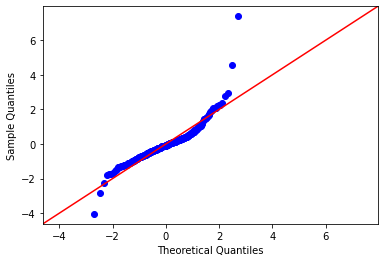

In [108]:
# 학습데이터의 잔차 확인

res = fitted_full_model.resid

# q-q plot을 통한 잔차의 정규분포 확인
fig = sm.qqplot(res, fit = True,line = '45')
plt.savefig("data/resid.png")

In [83]:
# MSE 구하기
from sklearn.metrics import mean_squared_error

x1 = last[['경사도', '자전거도로길이', '총거치대수', '인구', '면적', '지하철역개수', '버스정거장개수', '접근성']]
x1_ = sm.add_constant(x1, has_constant = "add")
target = last[['총대여수']]

X = x1_
y = target

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3, random_state = 1)

# 학습데이터와 검증데이터를 7:3으로 분리한다.
# random_state고정을 통해 그때마다 똑같은 값을 분류하도록 한다.
# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

fit_train1 = sm.OLS(train_y,train_x)
fit_train1 = fit_train1.fit()

mse1 = mean_squared_error(y_true = test_y["총대여수"], y_pred = fit_train1.predict(test_x))

print(mse1)

1427913020.236452


### 전진선택법(step=1)

In [84]:
import time
import itertools 

def processSubset(X,y,feature_set):
    model = sm.OLS(y,X[list(feature_set)]) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}

### 전진선택법 모델

def forward(X,y,predictors):
	
    # predictor - 현재 선택되어있는 변수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors :
    	results.append(processSubset(X=X,y=y,feature_set=predictors+[p]+['const']))
    
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)
    
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ",models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print("Selected predictors:",best_model["model"].model.exog_names,"AIC: ",best_model[0])
    return best_model
    
### 전진선택법 모델

def forward_model(X, y):

    Fmodels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    
    # 미리 정의된 데이터 변수
    predictors = []
    
    # 변수 1~10개 : 0-9 -> 1-10
    for i in range(1,len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result["AIC"] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [k for k in predictors if k != 'const']
        
    toc = time.time()
    print("Total elapsed time:",(toc-tic), "seconds.")
    
    return (Fmodels['model'][len(Fmodels['model'])])

In [85]:
Forward_best_model = forward_model(X=train_x, y=train_y)

Processed  8 models on 1 predictors in 0.018992185592651367
Selected predictors: ['총거치대수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000180E618D788>
Processed  7 models on 2 predictors in 0.017001867294311523
Selected predictors: ['총거치대수', '자전거도로길이', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000180E618D0C8>
Processed  6 models on 3 predictors in 0.018018484115600586
Selected predictors: ['총거치대수', '자전거도로길이', '경사도', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000180E619ED88>
Processed  5 models on 4 predictors in 0.01500082015991211
Selected predictors: ['총거치대수', '자전거도로길이', '경사도', '지하철역개수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000180E61BED88>
Processed  4 models on 5 predictors in 0.013001680374145508
Selected predictors: ['총거치대수', '자전거도로길이', '경사도', '지하철역개수', '인구', 'const'] AIC:  <statsmodels

In [86]:
Forward_best_model.aic

6913.718339206506

In [87]:
Forward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총대여수   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     61.48
Date:                Fri, 13 Nov 2020   Prob (F-statistic):           8.11e-49
Time:                        16:19:12   Log-Likelihood:                -3449.9
No. Observations:                 296   AIC:                             6914.
Df Residuals:                     289   BIC:                             6940.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총거치대수        455.3823     36.762     12.387      0.000     383.027     527.738
자전거도로길이        2.0781      0.511      4.068      0.000       1.073       3.083
경사도          101.7303     54.095      1.881      0.061      -4.739     208.200
지하철역개수      5422.2581   2207.340      2.456      0.015    1077.758    9766.759
인구             0.3028      0.186      1.631      0.104      -0.063       0.668
면적         -2191.8776   1394.530     -1.572      0.117   -4936.601     552.846
const       5972.8569   5310.894      1.125      0.262   -4480.079    1.64e+04
==============================================================================
Omnibus:                       94.878   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              947.015
Skew:                           0.984   Prob(JB):                    2.28e-206
Kurtosis:                      11.539   Cond. No.                     8.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# last1 = pd.read_excel("data/last_자전거이용비율수정.xlsx")
# last1.fillna(0, inplace=True) # 결측값 0으로 치환 
# last1 = last1.drop(last1.columns[[0, 6, 9]], axis=1) # unnamed:0 칼럼 지우기
# last1 = last1.set_index('동')

# feature_columns = last1.columns.difference(["총대여수"]) # Target column 

# X = last1[feature_columns]
# y = last1.총대여수

# train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.7, test_size = 0.3)

# print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

In [89]:
# # train & 회귀모델 적합, 모든 변수를 때려넣었다.

# # 회귀분석을 위해 for b0, 상수항 추가
# train_x_ = sm.add_constant(train_x, has_constant = "add")

# full_model = sm.OLS(train_y, train_x_)
# fitted_full_model = full_model.fit()

# fitted_full_model.summary()

### 후진소거법(step=1)

In [90]:
# import time
# import itertools 

# def backward(X,y,predictors):
#     tic = time.time()
#     results=[]
#     #데이터 변수들이 미리정의된 predictors 조합확인
#     for combo in itertools.combinations(predictors, len(predictors)-1):
#         results.append(processSubset(X,y,list(combo)+['const']))
#     models = pd.DataFrame(results)
#     #가장 낮은 AIC를 가진 모델을 선택
#     bestModel = models.loc[models['AIC'].argmin()]
#     toc = time.time()
#     print("Processed",models.shape[0],"models on",len(predictors)-1,
#           "predictors in",(toc - tic))
#     print("Selected predictors :",bestModel['model'].model.exog_names,
#           ' AIC:',bestModel[0])
#     return bestModel
 
# def backword_model(X,y):
#     BModels = pd.DataFrame(columns=["AIC","model"])
#     tic = time.time()
#     #미리 정의된 데이터 변수
#     predictors = x.columns.difference(['const'])
#     BmodelBefore = processSubset(X,y,predictors)['AIC']
#     while(len(predictors)>1):
#         backwardResult=backward(trainX,trainY,predictors)
#         if backwardResult['AIC'] > BmodelBefore:
#             break
#         BModels.loc[len(predictors)-1] = backwardResult
#         predictors = BModels.loc[len(predictors)-1]["model"].model.exog_names
#         BmodelBefore = backwardResult["AIC"]
#         predictors = [ k for k in predictors if k != 'const']
 
#     toc = time.time()
#     print("Total elapsed time :",(toc - tic), "seconds.")
#     return (BModels["model"].dropna().iloc[0])

In [91]:
# Backward_best_model = backward_model(X=train_x, y= train_y)

In [92]:
# Backward_best_model.aic

In [93]:
# Backward_best_model.summary()

### 단계적선택법

In [94]:
def Stepwise_model(X,y):
    stepModels = pd.DataFrame(columns=["AIC","model"])
    tic = time.time()
    predictors = []
    SmodelBefore = processSubset(X,y,predictors+['const'])['AIC']
    #변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const']))+1):
        forwardResult = forward(X,y,predictors)
        print("forward")
        stepModels.loc[i] = forwardResult
        predictors = stepModels.loc[i]["model"].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        backwordResult = backward(X,y,predictors)
        if backwordResult['AIC'] < forwardResult['AIC']:
            stepModels.loc[i] = backwordResult
            predictors=stepModels.loc[i]["model"].model.exog_names
            smodelBefore=stepModels.loc[i]["AIC"]
            predictors=[k for k in predictors if k != 'const']
            print('backward')
        if stepModels.loc[i]["AIC"] > SmodelBefore:
            break
        else:
            smodelBefore = stepModels.loc[i]["AIC"]
    toc=time.time()
    print("Total elapsed time : ", (toc - tic), "seconds")
    return (stepModels['model'][len(stepModels['model'])])

In [95]:
Stepwise_best_model = Stepwise_model(X=train_x, y= train_y)

Processed  8 models on 1 predictors in 0.01799798011779785
Selected predictors: ['총거치대수', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000180E613CE48>
forward
Processed 1 models on 0 predictors in 0.003997802734375
Selected predictors : ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000180E6130EC8>
Processed  7 models on 2 predictors in 0.023000001907348633
Selected predictors: ['총거치대수', '자전거도로길이', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000180E6121C08>
forward
Processed 2 models on 1 predictors in 0.008003711700439453
Selected predictors : ['총거치대수', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x00000180E613C9C8>
Processed  6 models on 3 predictors in 0.015999317169189453
Selected predictors: ['총거치대수', '자전거도로길이', '경사도', 'const'] AIC:  <statsmodels.regression.linear_model.RegressionResultsWrapper object a

In [96]:
Stepwise_best_model.aic

6913.718339206506

In [97]:
Stepwise_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   총대여수   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     61.48
Date:                Fri, 13 Nov 2020   Prob (F-statistic):           8.11e-49
Time:                        16:19:15   Log-Likelihood:                -3449.9
No. Observations:                 296   AIC:                             6914.
Df Residuals:                     289   BIC:                             6940.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
총거치대수        455.3823     36.762     12.387      0.000     383.027     527.738
자전거도로길이        2.0781      0.511      4.068      0.000       1.073       3.083
경사도          101.7303     54.095      1.881      0.061      -4.739     208.200
지하철역개수      5422.2581   2207.340      2.456      0.015    1077.758    9766.759
인구             0.3028      0.186      1.631      0.104      -0.063       0.668
면적         -2191.8776   1394.530     -1.572      0.117   -4936.601     552.846
const       5972.8569   5310.894      1.125      0.262   -4480.079    1.64e+04
==============================================================================
Omnibus:                       94.878   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              947.015
Skew:                           0.984   Prob(JB):                    2.28e-206
Kurtosis:                      11.539   Cond. No.                     8.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
# 성능평가
# number of params
print(Forward_best_model.params.shape, Stepwise_best_model.params.shape)

(7,) (7,)


In [99]:
# 모델에 의해 예측된/추정된 값 = test_y

pred_y_forward = Forward_best_model.predict(test_x[Forward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])

In [104]:
# MSE, RMSE, MAE, MAPE 4가지 지표를 통해 예측성능을 확인할 예정

perf_mat = pd.DataFrame(columns=["FORWARD", "STEPWISE"],index =['MSE', 'RMSE','MAE'])

# MAPE의 함수
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn import metrics  # 나머지는 sklearn에서 활용

# 성능지표
perf_mat.loc['MSE']['FORWARD'] = metrics.mean_squared_error(test_y,pred_y_forward)
perf_mat.loc['MSE']['STEPWISE'] = metrics.mean_squared_error(test_y,pred_y_stepwise)

perf_mat.loc['RMSE']['FORWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_forward))
perf_mat.loc['RMSE']['STEPWISE'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_stepwise))

perf_mat.loc['MAE']['FORWARD'] = metrics.mean_absolute_error(test_y, pred_y_forward)
perf_mat.loc['MAE']['STEPWISE'] = metrics.mean_absolute_error(test_y, pred_y_stepwise)


print(perf_mat)

          FORWARD     STEPWISE
MSE   1.43916e+09  1.43916e+09
RMSE      37936.2      37936.2
MAE       21361.2      21361.2
